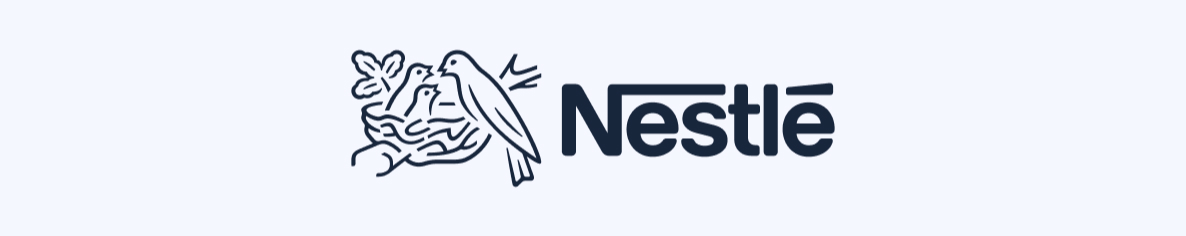

# Projeto Nestle

**Descrição:** Este notebook realiza o carregamento, tratamento e transformação de 6 bases CSV para análise de dados e integração com a camada Processed.

## Estrutura do Notebook
O Notebook esta estruturado conforme as 6 bases:
- Cargo;
- Cep;
- Clientes;
- Clientes;
- Funcionarios;
- Nivel.

Para cada base, o processo começa com uma análise detalhada para identificar os pontos que precisam de tratamento e validações básicas. Em seguida, realiza-se o tratamento dos dados necessários, seguido pela carga na camada Silver.

#### Bibliotecas Importadas
As bibliotecas principais utilizadas no projeto incluem:
- Funções como col, trim, when, lit, to_date e regexp_replace para manipulação de dados.

In [0]:
from pyspark.sql.functions import count, col, trim, when, lit, to_date, regexp_replace, date_format, date_add, expr, monotonically_increasing_id
from pyspark.sql.types import IntegerType, StringType, DateType, StructField, StructType, DoubleType
import re

#### Autenticação no Azure Data Lake Gen2
É necessário configurar o acesso ao Azure Data Lake fornecendo a chave da conta de armazenamento:

Substitua:
- `STORAGE_ACCOUNT` pelo nome da sua conta de armazenamento.

- `STORAGE_ACCOUNT_KEY` pela chave de acesso.

In [0]:
spark.conf.set(
    "fs.azure.account.key.storagenestlecase.dfs.core.windows.net", 
    'sua_chave')

In [0]:
# Listar arquivos do Data Lake
dbutils.fs.ls("abfss://raw@storagenestlecase.dfs.core.windows.net")

[FileInfo(path='abfss://raw@storagenestlecase.dfs.core.windows.net/BaseCEP.csv', name='BaseCEP.csv', size=24695, modificationTime=1737383396000),
 FileInfo(path='abfss://raw@storagenestlecase.dfs.core.windows.net/BaseCargos.csv', name='BaseCargos.csv', size=1362, modificationTime=1737383396000),
 FileInfo(path='abfss://raw@storagenestlecase.dfs.core.windows.net/BaseClientes.csv', name='BaseClientes.csv', size=19009, modificationTime=1737383396000),
 FileInfo(path='abfss://raw@storagenestlecase.dfs.core.windows.net/BaseFuncionarios.csv', name='BaseFuncionarios.csv', size=99764, modificationTime=1737383396000),
 FileInfo(path='abfss://raw@storagenestlecase.dfs.core.windows.net/BaseNível.csv', name='BaseNível.csv', size=340, modificationTime=1737383396000),
 FileInfo(path='abfss://raw@storagenestlecase.dfs.core.windows.net/BasePQ.csv', name='BasePQ.csv', size=103983, modificationTime=1737659006000)]

#### Configurações Adicionais

Para otimizar o processamento:
- Ative o suporte ao Apache Arrow para acelerar operações.
- Ajuste o número de partições para 200.
- Habilite otimizações adaptativas.

In [0]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.shuffle.partitions", "200")
spark.conf.set("spark.sql.adaptive.enabled", "true")

#### Leitura dos Dados
Carregando o arquivo CSV direto da camada Bronze.

In [0]:
file_paths = [
    "abfss://raw@storagenestlecase.dfs.core.windows.net/BaseCargos.csv",
    "abfss://raw@storagenestlecase.dfs.core.windows.net/BaseCEP.csv",
    "abfss://raw@storagenestlecase.dfs.core.windows.net/BaseClientes.csv",
    "abfss://raw@storagenestlecase.dfs.core.windows.net/BaseFuncionarios.csv",
    "abfss://raw@storagenestlecase.dfs.core.windows.net/BaseNível.csv",
    "abfss://raw@storagenestlecase.dfs.core.windows.net/BasePQ.csv"
]

base_cargos = spark.read.option("delimiter", ";").csv(file_paths[0], header=True, inferSchema=True)
base_cep = spark.read.option("delimiter", "|").csv(file_paths[1], header=True, inferSchema=True)
base_clientes = spark.read.option("delimiter", ";").csv(file_paths[2], header=True, inferSchema=True)
base_funcionarios = spark.read.option("delimiter", "||").csv(file_paths[3], header=True, inferSchema=True)
base_nivel = spark.read.option("delimiter", "%").csv(file_paths[4], header=True, inferSchema=True)
base_pq = spark.read.option("delimiter", ";").csv(file_paths[5], header=True, inferSchema=True)

# Base Cargos

#### Visualização da Base de Cargos
Nesta etapa, exibimos os dados da base `base_cargos` para validação inicial e compreensão do seu conteúdo.

In [0]:
display(base_cargos)

Cargo,Nível,Área,COD Área,COD Nível,Quadro,Bonus,Contratacao
OPV,Diretor,Operações,JAJ,JE,Efetivo,S,Diretoria
LOI,Estagiário,Logísitca,EDE,JA,Efetivo,N,Gerente
ADI,Estagiário,Administrativo,BAC,JA,Efetivo,N,Gerente
ADII,Analista,Administrativo,BAC,DB,Terceiro,N,RH
OPII,Analista,Operações,JAJ,DB,Terceiro,N,RH
FIV,Diretor,Financeiro,CBB,JE,Efetivo,S,Diretoria
FIII,Analista,Financeiro,CBB,DB,Terceiro,N,RH
ADIII,Coordenador,Administrativo,BAC,DB,Terceiro,N,RH
LOIV,null,Gerente,Logísitca,EDE,ID,Efetivo,S
FII,Estagiário,Financeiro,CBB,JA,Efetivo,N,Gerente


#### Validações Iniciais
Ao começar a trabalhar com dados em PySpark, é fundamental realizar algumas validações iniciais para garantir que os dados estão consistentes e prontos para processamento.

In [0]:
# Verifica a existencia de valores nulos
valores_nulos = base_cargos.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cargos.columns])
valores_nulos_df = valores_nulos.collect()[0].asDict()

if any(value > 0 for value in valores_nulos_df.values()):
    display(valores_nulos_df)
else:
    print("Valores nulos não encontrados")

{'Cargo': 0,
 'Nível': 5,
 'Área': 0,
 'COD Área': 0,
 'COD Nível': 0,
 'Quadro': 0,
 'Bonus': 0,
 'Contratacao': 0}

In [0]:
# Verifica a existencia de duplicatas
duplicates = base_cargos.count() - base_cargos.dropDuplicates().count()
print(f"Número de duplicatas: {duplicates}")

Número de duplicatas: 0


In [0]:
# Verifica a existencia de espaços nas linhas
for column in base_cargos.columns:
    count = base_cargos.filter(col(column) != trim(col(column))).count()
    print(f"{column}: {count}")


Cargo: 0
Nível: 0
Área: 0
COD Área: 2
COD Nível: 1
Quadro: 0
Bonus: 0
Contratacao: 0


#### Transformações e Limpeza dos Dados
Aplicação de transformações para corrigir inconsistências, tratar valores ausentes e preparar os dados para a próxima etapa do pipeline.

In [0]:
# Renomear colunas
base_cargos = base_cargos.withColumnRenamed("Cargo", "cargo") \
                         .withColumnRenamed("Nível", "nivel") \
                         .withColumnRenamed("Área", "area") \
                         .withColumnRenamed("COD Área", "cod_area") \
                         .withColumnRenamed("COD Nível", "cod_nivel") \
                         .withColumnRenamed("Quadro", "quadro") \
                         .withColumnRenamed("Bonus", "bonus") \
                         .withColumnRenamed("Contratacao", "contratacao")
# display(base_cargos)

In [0]:
# Alterar os valores nulos para 'Não Informado'
base_cargos = base_cargos.fillna("Não Informado")
# display(base_cargos)

In [0]:
# Retirando espaços nas linhas
base_cargos = base_cargos.select([trim(col(c)).alias(c) for c in base_cargos.columns])
# display(base_cargos)

In [0]:
# Remoção do caractere '@' de todas as ocorrências nas linhas da coluna area
base_cargos = base_cargos.withColumn('area', regexp_replace('area', '@@@', ''))
# display(base_cargos)

In [0]:
# Definição das alterações em um dicionário para facilitar a leitura
alteracoes = {
    "LOIV": {
        "nivel": [("Não Informado", "Gerente")],
        "area": [("Gerente", "Logística")],
        "cod_area": [("Logística", "EDE")],
        "cod_nivel": [("Logística", "ID")],
        "quadro": [("ID", "Efetivo")],
        "bonus": [("Efetivo", "S")],
        "contratacao": [("S", "Não Informado")]
    },
    "COIII": {
        "nivel": [("Não Informado", "Coordenador")],
        "area": [("Coordenador", "Comercial")],
        "cod_area": [("Comercial", "JAA")],
        "cod_nivel": [("JAA", "DB")],
        "quadro": [("DB", "Terceiro")],
        "bonus": [("Terceiro", "N")],
        "contratacao": [("N", "Não Informado")]
    },
    "COII": {
        "nivel": [("Não Informado", "Analista")],
        "area": [("Analista", "Comercial")],
        "cod_area": [("Comercial", "JAA")],
        "cod_nivel": [("JAA", "DB")],
        "quadro": [("DB", "Terceiro")],
        "bonus": [("Terceiro", "N")],
        "contratacao": [("N", "Não Informado")]
    },
    "ADIV": {
        "nivel": [("Não Informado", "Gerente")],
        "area": [("Gerente", "Administrativo")],
        "cod_area": [("Administrativo", "BAC")],
        "cod_nivel": [("BAC", "ID")],
        "quadro": [("ID", "Efetivo")],
        "bonus": [("Efetivo", "S")],
        "contratacao": [("S", "Não Informado")]
    },
    "FIIV": {
        "nivel": [("Não Informado", "Gerente")],
        "area": [("Gerente", "Financeiro")],
        "cod_area": [("Financeiro", "CBB")],
        "cod_nivel": [("CBB", "ID")],
        "quadro": [("ID", "Efetivo")],
        "bonus": [("Efetivo", "S")],
        "contratacao": [("S", "Não Informado")]
    }
}

# Aplicando as alterações para cada cargo
for cargo, colunas in alteracoes.items():
    for coluna, condicoes in colunas.items():
        for condicao_atual, novo_valor in condicoes:
            base_cargos = base_cargos.withColumn(
                coluna,
                when((col("cargo") == cargo) & (col(coluna) == condicao_atual), novo_valor).otherwise(col(coluna))
            )

In [0]:
# Visualização dos dados tratados
display(base_cargos)

cargo,nivel,area,cod_area,cod_nivel,quadro,bonus,contratacao
OPV,Diretor,Operações,JAJ,JE,Efetivo,S,Diretoria
LOI,Estagiário,Logísitca,EDE,JA,Efetivo,N,Gerente
ADI,Estagiário,Administrativo,BAC,JA,Efetivo,N,Gerente
ADII,Analista,Administrativo,BAC,DB,Terceiro,N,RH
OPII,Analista,Operações,JAJ,DB,Terceiro,N,RH
FIV,Diretor,Financeiro,CBB,JE,Efetivo,S,Diretoria
FIII,Analista,Financeiro,CBB,DB,Terceiro,N,RH
ADIII,Coordenador,Administrativo,BAC,DB,Terceiro,N,RH
LOIV,Gerente,Logística,Logísitca,EDE,Efetivo,S,Não Informado
FII,Estagiário,Financeiro,CBB,JA,Efetivo,N,Gerente


#### Envio de dados para camada Processed
Após todo o tratamento dos dados da base Cargos, os dados são carregados na camada Processed.

In [0]:
processed = "abfss://processed@storagenestlecase.dfs.core.windows.net/processed/BaseCargos.parquet"
base_cargos.write.mode("overwrite").parquet(processed)

# Base CEP

#### Visualização da Base de Cargos
Nesta etapa, exibimos os dados da base `base_cep` para validação inicial e compreensão do seu conteúdo.

In [0]:
display(base_cep)

CEP,Estado,Região
20125535,Mato Grosso,Centro - Oeste
25995770,Rio Grande do Norte,Nordeste
37278465,Sergipe,Nordeste
49897703,Mato Grosso,Centro - Oeste
30149335,Mato Grosso,Centro - Oeste
22796750,Rio de Janeiro,Sudeste
44060184,Pernambuco,Nordeste
43115256,Goiás,Centro - Oeste
34949262,null,Pará
34786165,null,Pernambuco


#### Validações Iniciais
Ao começar a trabalhar com dados em PySpark, é fundamental realizar algumas validações iniciais para garantir que os dados estão consistentes e prontos para processamento.

In [0]:
# Verifica a existencia de valores nulos
valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
valores_nulos_df = valores_nulos.collect()[0].asDict()

if any(value > 0 for value in valores_nulos_df.values()):
    display(valores_nulos_df)
else:
    print("Valores nulos não encontrados")

{'CEP': 0, 'Estado': 25, 'Região': 0}

In [0]:
# Verifica a existencia de duplicatas
duplicates = base_cep.count() - base_cep.dropDuplicates().count()
print(f"Número de duplicatas: {duplicates}")

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

#### Transformações e Limpeza dos Dados
Aplicação de transformações para corrigir inconsistências, tratar valores ausentes e preparar os dados para a próxima etapa do pipeline.

In [0]:
# Renomear as colunas
base_cep = base_cep.withColumnRenamed("CEP", "cep") \
                         .withColumnRenamed("Estado", "estado") \
                         .withColumnRenamed("Região", "regiao") 

In [0]:
# Transformar a coluna CEP em varchar
base_cep = base_cep.withColumn("cep", base_cep["cep"].cast("string"))

In [0]:
# preenchendo a coluna 'regiao' com o valor correto baseado no estado
base_cep = base_cep.withColumn(
    'estado',
    when(col('regiao') == 'Pará', 'Pará')
    .when(col('regiao') == 'Pernambuco', 'Pernambuco')
    .when(col('regiao') == 'Rio Grande do Norte', 'Rio Grande do Norte')
    .when(col('regiao') == 'Mato Grosso', 'Mato Grosso')
    .when(col('regiao') == 'Sergipe', 'Sergipe')
    .when(col('regiao') == 'Acre', 'Acre')
    .when(col('regiao') == 'Amapá', 'Amapá')
    .when(col('regiao') == 'Santa Catarina', 'Santa Catarina')
    .when(col('regiao') == 'Rio Grande do Sul', 'Rio Grande do Sul')
    .when(col('regiao') == 'Bahia', 'Bahia')
    .when(col('regiao') == 'Minas Gerais', 'Minas Gerais')
    .when(col('regiao') == 'Alagoas', 'Alagoas')
    .otherwise(col('estado'))  # Manter o valor original caso não se encaixe em nenhum caso
).withColumn(
    'regiao',
    when(col('estado') == 'Pará', 'Nordeste')  # Alterando 'regiao' para o valor correto
    .when(col('estado') == 'Pernambuco', 'Nordeste')
    .when(col('estado') == 'Rio Grande do Norte', 'Nordeste')
    .when(col('estado') == 'Mato Grosso', 'Centro - Oeste')
    .when(col('estado') == 'Sergipe', 'Nordeste')
    .when(col('estado') == 'Acre', 'Norte')
    .when(col('estado') == 'Amapá', 'Norte')
    .when(col('estado') == 'Santa Catarina', 'Sul')
    .when(col('estado') == 'Rio Grande do Sul', 'Sul')
    .when(col('estado') == 'Bahia', 'Nordeste')
    .when(col('estado') == 'Minas Gerais', 'Sudeste')
    .when(col('estado') == 'Alagoas', 'Nordeste')
    .otherwise(col('regiao'))  # Caso não se encaixe em nenhum valor, mantém o valor original
)


In [0]:
# Visualização dos dados tratados
display(base_cep)

cep,estado,regiao
20125535,Mato Grosso,Centro - Oeste
25995770,Rio Grande do Norte,Nordeste
37278465,Sergipe,Nordeste
49897703,Mato Grosso,Centro - Oeste
30149335,Mato Grosso,Centro - Oeste
22796750,Rio de Janeiro,Sudeste
44060184,Pernambuco,Nordeste
43115256,Goiás,Centro - Oeste
34949262,Pará,Nordeste
34786165,Pernambuco,Nordeste


#### Envio de dados para camada Processed
Após todo o tratamento dos dados da base Cargos, os dados são carregados na camada Processed.

In [0]:
processed = "abfss://processed@storagenestlecase.dfs.core.windows.net/processed/BaseCep.parquet"
base_cep.write.mode("overwrite").parquet(processed)

# Base Clientes

#### Visualização da Base de Cargos
Nesta etapa, exibimos os dados da base `base_clientes` para validação inicial e compreensão do seu conteúdo.

In [0]:
display(base_clientes)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

#### Validações Iniciais
Ao começar a trabalhar com dados em PySpark, é fundamental realizar algumas validações iniciais para garantir que os dados estão consistentes e prontos para processamento.

In [0]:
# Verifica a existencia de valores nulos
valores_nulos = base_clientes.select([count(when(col(c).isNull(), c)).alias(c) for c in base_clientes.columns])
valores_nulos_df = valores_nulos.collect()[0].asDict()

if any(value > 0 for value in valores_nulos_df.values()):
    display(valores_nulos_df)
else:
    print("Valores nulos não encontrados")

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

In [0]:
# Verifica a existencia de duplicatas
duplicates = base_clientes.count() - base_cargos.dropDuplicates().count()
print(f"Número de duplicatas: {duplicates}")

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

#### Transformações e Limpeza dos Dados
Aplicação de transformações para corrigir inconsistências, tratar valores ausentes e preparar os dados para a próxima etapa do pipeline.

In [0]:
# Remover colunas que não serão utilizadas
base_clientes = base_clientes.drop("_c7", "_c8", "_c9", "_c10", "_c11")

In [0]:
# Renomear colunas
base_clientes = base_clientes.withColumnRenamed("Cliente", "cliente") \
                         .withColumnRenamed("Valor Contrato Anual", "valor_contrato_anual") \
                         .withColumnRenamed("Quantidade de Serviços", "quantidade_servicos") \
                         .withColumnRenamed("Cargo Responsável", "cargo_responsavel") \
                         .withColumnRenamed("CEP", "cep") \
                         .withColumnRenamed("Data Início Contrato", "data_inicio_contrato") \
                         .withColumnRenamed("Nivel de Importancia", "nivel_importancia")

In [0]:
# Substituir valores nulos em 'quantidade_servicos' por 'desconhecido'
base_clientes = base_clientes.fillna('Vazio')

In [0]:
# A seguir, a coluna 'quantidade_servicos' será preenchida com o valor da coluna 'cargo_responsavel' onde 'quantidade_servicos' estiver com valor 'Vazio'.
# Em paralelo, a coluna 'cargo_responsavel' será preenchida com 'Vazio' onde 'quantidade_servicos' for igual a 'cargo_responsavel'.
base_clientes = base_clientes.withColumn(
    'quantidade_servicos',
    when(col('quantidade_servicos') == 'Vazio', col('cargo_responsavel'))
    .otherwise(col('quantidade_servicos'))
).withColumn(
    'cargo_responsavel',
    when(col('quantidade_servicos') == col('cargo_responsavel'), 'Vazio')
    .otherwise(col('cargo_responsavel'))
)

# Agora, a coluna 'cargo_responsavel' será substituída pelo valor de 'cep' quando 'cargo_responsavel' for 'Vazio'.
# Ao mesmo tempo, a coluna 'cep' será substituída por 'Vazio' quando 'cargo_responsavel' for igual ao seu valor.
base_clientes = base_clientes.withColumn(
    'cargo_responsavel',
    when(col('cargo_responsavel') == 'Vazio', col('cep'))
    .otherwise(col('cargo_responsavel'))
).withColumn(
    'cep',
    when(col('cargo_responsavel') == col('cep'), 'Vazio')
    .otherwise(col('cep'))
)

# Na sequência, o valor da coluna 'cep' será substituído pelo valor de 'data_inicio_contrato' onde 'cep' estiver com valor 'Vazio'.
# 'data_inicio_contrato' será alterado para 'Vazio' quando for igual a 'cep'.
base_clientes = base_clientes.withColumn(
    'cep',
    when(col('cep') == 'Vazio', col('data_inicio_contrato'))
    .otherwise(col('cep'))
).withColumn(
    'data_inicio_contrato',
    when(col('cep') == col('data_inicio_contrato'), 'Vazio')
    .otherwise(col('data_inicio_contrato'))
)

# Em seguida, o valor de 'data_inicio_contrato' será substituído por 'nivel_importancia' quando 'data_inicio_contrato' estiver com valor 'Vazio'.
# Ao mesmo tempo, 'nivel_importancia' será preenchido com 'Vazio' quando 'data_inicio_contrato' for igual a 'nivel_importancia'.
base_clientes = base_clientes.withColumn(
    'data_inicio_contrato',
    when(col('data_inicio_contrato') == 'Vazio', col('nivel_importancia'))
    .otherwise(col('data_inicio_contrato'))
).withColumn(
    'nivel_importancia',
    when(col('data_inicio_contrato') == col('nivel_importancia'), 'Vazio')
    .otherwise(col('nivel_importancia'))
)

# Repetição do processo anterior para garantir que a coluna 'nivel_importancia' seja corretamente substituída por 'data_inicio_contrato'.
base_clientes = base_clientes.withColumn(
    'data_inicio_contrato',
    when(col('data_inicio_contrato') == 'Vazio', col('nivel_importancia'))
    .otherwise(col('data_inicio_contrato'))
).withColumn(
    'nivel_importancia',
    when(col('data_inicio_contrato') == col('nivel_importancia'), 'Vazio')
    .otherwise(col('nivel_importancia'))
)

# Para o cliente 'OPV', alteraremos o valor de 'data_inicio_contrato' para '05/04/2019' e a 'quantidade_servicos' para 'Vazio'.
base_clientes = base_clientes.withColumn(
    'data_inicio_contrato',
    when(
        col('cliente') == 'OPV',  # Caso cliente seja 'OPV'
        lit('05/04/2019')  # Atribuir '05/04/2019' a 'data_inicio_contrato'
    ).otherwise(col('data_inicio_contrato'))  # Caso contrário, manter o valor original de 'data_inicio_contrato'
).withColumn(
    'quantidade_servicos',
    when(
        col('cliente') == 'OPV',  # Caso cliente seja 'OPV'
        lit('Vazio')  # Atribuir 'Vazio' a 'quantidade_servicos'
    ).otherwise(col('quantidade_servicos'))  # Caso contrário, manter o valor original de 'quantidade_servicos'
)

# Agora, para o cliente 'OPV' com 'cargo_responsavel' igual a '1', os valores de 'cliente' e 'cargo_responsavel' serão trocados.
base_clientes = base_clientes.withColumn(
    'temp_cliente',
    when(
        (col('cliente') == 'OPV') & (col('cargo_responsavel') == '1'),
        col('cargo_responsavel')
    ).otherwise(col('cliente'))
).withColumn(
    'temp_cargo_responsavel',
    when(
        (col('cliente') == 'OPV') & (col('cargo_responsavel') == '1'),
        col('cliente')
    ).otherwise(col('cargo_responsavel'))
).withColumn(
    'cliente',
    col('temp_cliente')
).withColumn(
    'cargo_responsavel',
    col('temp_cargo_responsavel')
).drop('temp_cliente', 'temp_cargo_responsavel')

# Para o cliente '1', a coluna 'nivel_importancia' será alterada para 'Vazio' quando 'nivel_importancia' estiver com esse valor, e a coluna 'cliente' será alterada para 'nivel_importancia'.
base_clientes = base_clientes.withColumn(
    'temp_cliente',
    when(
        (col('cliente') == '1') & (col('nivel_importancia') == 'Vazio'),
        col('nivel_importancia')
    ).otherwise(col('cliente'))
).withColumn(
    'temp_nivel_importancia',
    when(
        (col('cliente') == '1') & (col('nivel_importancia') == 'Vazio'),
        col('cliente')
    ).otherwise(col('nivel_importancia'))
).withColumn(
    'cliente',
    col('temp_cliente')
).withColumn(
    'nivel_importancia',
    col('temp_nivel_importancia')
).drop('temp_cliente', 'temp_nivel_importancia')

# Para o valor '615313104' da coluna 'valor_contrato_anual', vamos substituir 'cep' por esse valor e vice-versa.
base_clientes = base_clientes.withColumn(
    'temp_valor_contrato_anual',
    when(
        (col('valor_contrato_anual') == '615313104') & (col('cep') == 'Vazio'),
        col('cep')
    ).otherwise(col('valor_contrato_anual'))
).withColumn(
    'temp_cep',
    when(
        (col('valor_contrato_anual') == '615313104') & (col('cep') == 'Vazio'),
        col('valor_contrato_anual')
    ).otherwise(col('cep'))
).withColumn(
    'valor_contrato_anual',
    col('temp_valor_contrato_anual')
).withColumn(
    'cep',
    col('temp_cep')
).drop('temp_valor_contrato_anual', 'temp_cep')

# Para o cliente 'FIIV' com 'cargo_responsavel' igual a '4', vamos inverter os valores de 'cliente' e 'cargo_responsavel'.
base_clientes = base_clientes.withColumn(
    'temp_cliente',
    when(
        (col('cliente') == 'FIIV') & (col('cargo_responsavel') == '4'),
        col('cargo_responsavel')
    ).otherwise(col('cliente'))
).withColumn(
    'temp_cargo_responsavel',
    when(
        (col('cliente') == 'FIIV') & (col('cargo_responsavel') == '4'),
        col('cliente')
    ).otherwise(col('cargo_responsavel'))
).withColumn(
    'cliente',
    col('temp_cliente')
).withColumn(
    'cargo_responsavel',
    col('temp_cargo_responsavel')
).drop('temp_cliente', 'temp_cargo_responsavel')

# Para o valor '148112796' da coluna 'valor_contrato_anual', realizamos a troca com 'cep', onde 'cep' estiver com valor 'Vazio'.
base_clientes = base_clientes.withColumn(
    'temp_valor_contrato_anual',
    when(
        (col('valor_contrato_anual') == '148112796') & (col('cep') == 'Vazio'),
        col('cep')
    ).otherwise(col('valor_contrato_anual'))
).withColumn(
    'temp_cep',
    when(
        (col('valor_contrato_anual') == '148112796') & (col('cep') == 'Vazio'),
        col('valor_contrato_anual')
    ).otherwise(col('cep'))
).withColumn(
    'valor_contrato_anual',
    col('temp_valor_contrato_anual')
).withColumn(
    'cep',
    col('temp_cep')
).drop('temp_valor_contrato_anual', 'temp_cep')

# Para a data de '15/01/2019' na coluna 'quantidade_servicos', faremos a troca com 'data_inicio_contrato', onde 'data_inicio_contrato' estiver 'Vazio'.
base_clientes = base_clientes.withColumn(
    'temp_quantidade_servicos',
    when(
        (col('quantidade_servicos') == '


In [0]:
# Substitui o valor "Vazio" por valores padrão nas colunas especificadas
base_clientes = base_clientes.select(
    *[
        when(col(c) == "Vazio", replacement).otherwise(col(c)).alias(c)
        for c, replacement in {
            "valor_contrato_anual": 0,
            "quantidade_servicos": 0,
            "cargo_responsavel": "Não Informado",
            "cep": "Não Informado",
            "data_inicio_contrato": "1900-01-01",
            "nivel_importancia": 0
        }.items()
    ]
)


In [0]:
# Convertendo as colunas para os tipos apropriados no DataFrame
base_clientes = base_clientes.select(
    col("valor_contrato_anual").cast(IntegerType()).alias("valor_contrato_anual"),
    col("quantidade_servicos").cast(IntegerType()).alias("quantidade_servicos"),
    col("cargo_responsavel").cast(StringType()).alias("cargo_responsavel"),
    col("cep").cast(StringType()).alias("cep"),
    to_date(col("data_inicio_contrato"), "dd/MM/yyyy").alias("data_inicio_contrato"),
    col("nivel_importancia").cast(IntegerType()).alias("nivel_importancia")
)

# Substituindo valores null na coluna 'data_inicio_contrato' por '01/01/1900'
base_clientes = base_clientes.withColumn(
    "data_inicio_contrato",
    when(col("data_inicio_contrato").isNull(), "01/01/1900")  # Substitui null por 01/01/1900
    .otherwise(col("data_inicio_contrato"))  # Deixa as outras datas como estão
)


In [0]:
display(base_clientes)

valor_contrato_anual,quantidade_servicos,cargo_responsavel,cep,data_inicio_contrato,nivel_importancia
54000,37,ADIII,743419711,2019-03-15,3
126000,12,FIIV,882467283,2019-04-08,1
319500,23,ADII,295150983,2019-02-09,3
252000,64,FIIV,430169311,2019-03-10,0
351000,19,OPV,839424894,2019-01-31,0
234000,47,OPIII,349268744,2019-03-16,0
135000,61,Não Informado,Não Informado,01/01/1900,0
0,0,OPV,615313104,2019-04-05,1
306000,35,LOV,395907462,2018-12-14,3
112500,75,COII,669105848,2019-01-27,4


#### Envio de dados para camada Processed
Após todo o tratamento dos dados da base Cargos, os dados são carregados na camada Processed.

In [0]:
processed = "abfss://processed@storagenestlecase.dfs.core.windows.net/processed/BaseClientes.parquet"
base_clientes.write.mode("overwrite").parquet(processed)

# Base Funcionarios


#### Visualização da Base de Funcionarios
Nesta etapa, exibimos os dados da base `base_funcionarios` para validação inicial e compreensão do seu conteúdo.

In [0]:
display(base_funcionarios)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

#### Validações Iniciais
Ao começar a trabalhar com dados em PySpark, é fundamental realizar algumas validações iniciais para garantir que os dados estão consistentes e prontos para processamento.

In [0]:
# Verifica a existencia de valores nulos
valores_nulos = base_funcionarios.select([count(when(col(c).isNull(), c)).alias(c) for c in base_funcionarios.columns])
valores_nulos_df = valores_nulos.collect()[0].asDict()

if any(value > 0 for value in valores_nulos_df.values()):
    display(valores_nulos_df)
else:
    print("Valores nulos não encontrados")

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

In [0]:
# Verifica a existencia de duplicatas
duplicates = base_funcionarios.count() - base_funcionarios.dropDuplicates().count()
print(f"Número de duplicatas: {duplicates}")

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

#### Transformações e Limpeza dos Dados
Aplicação de transformações para corrigir inconsistências, tratar valores ausentes e preparar os dados para a próxima etapa do pipeline.

In [0]:
# Remover colunas que não serão utilizadas
base_funcionarios = base_funcionarios.drop("ID RH", "id_pessoal", "bandeira")

In [0]:
#Renomear as colunas
base_funcionarios = base_funcionarios.withColumnRenamed("RG", "rg") \
                         .withColumnRenamed("CPF", "cpf") \
                         .withColumnRenamed("Ramal", "ramal") \
                         .withColumnRenamed("Estado Civil", "estado_civil") \
                         .withColumnRenamed("Nome Completo", "nome_completo") \
                         .withColumnRenamed("Login", "login") \
                         .withColumnRenamed("Data de Nascimento", "data_nascimento") \
                         .withColumnRenamed("CEP", "cep") \
                         .withColumnRenamed("Data de Contratacao", "data_contratacao") \
                         .withColumnRenamed("Data de Demissao", "data_demissao") \
                         .withColumnRenamed("Dias Uteis Trabalhados Ano Orcamentario", "dias_uteis_ano_orcamentario") \
                         .withColumnRenamed("Salario Base", "salario_base") \
                         .withColumnRenamed("Impostos", "impostos") \
                         .withColumnRenamed("Beneficios", "beneficios") \
                         .withColumnRenamed("VT", "vt") \
                         .withColumnRenamed("VR", "vr") \
                         .withColumnRenamed("Cargo", "cargo") \
                         .withColumnRenamed("Bandeira", "bandeira") \
                         .withColumnRenamed("Codigos", "codigos") \
                         .withColumnRenamed("Quantidade de Acessos", "quantidade_acessos") \
                         .withColumnRenamed("Ferias Acumuladas", "ferias_acumuladas") \
                         .withColumnRenamed("Ferias Remuneradas", "ferias_remuneradas") \
                         .withColumnRenamed("Horas Extras", "horas_extras") \
                         .withColumnRenamed("Valores Adicionais", "valores_adicionais") \
                         .withColumnRenamed("ID de Pessoal", "id_pessoal") \
                         .withColumnRenamed("ID da area", "id_area")                 

In [0]:
# Alterando a coluna 'ramal' para tipo inteiro
base_funcionarios = base_funcionarios.withColumn("ramal", col("ramal").cast(IntegerType()))

# Supondo que base_funcionarios seja o DataFrame
base_funcionarios = base_funcionarios.withColumn("rg", base_funcionarios["rg"].cast(StringType())) \
                                     .withColumn("cpf", base_funcionarios["cpf"].cast(StringType()))

# Alterando os valores da coluna 'estado_civil'
base_funcionarios = base_funcionarios.withColumn(
    'estado_civil',
    when(base_funcionarios['estado_civil'] == 'C', 'Casado')
     .when(base_funcionarios['estado_civil'] == 'S', 'Solteiro')
     .otherwise(base_funcionarios['estado_civil'])
)

# Convertendo o valor numérico para uma data e formatando para 'dd/MM/yyyy'
base_funcionarios = base_funcionarios.withColumn(
    'data_nascimento',
    date_format(date_add(lit('1900-01-01'), base_funcionarios['data_nascimento']), 'dd/MM/yyyy')
)

# Alterando o tipo da coluna 'cep' para string
base_funcionarios = base_funcionarios.withColumn('cep', base_funcionarios['cep'].cast('string'))


# Convertendo o valor numérico para uma data e formatando para 'dd/MM/yyyy'
base_funcionarios = base_funcionarios.withColumn(
    'data_contratacao',
    date_format(date_add(lit('1900-01-01'), base_funcionarios['data_contratacao']), 'dd/MM/yyyy')
)

# Substituindo os valores nulos por 1900-01-01, convertendo os valores de int para data
base_funcionarios = base_funcionarios.withColumn(
    'data_demissao', 
    when(base_funcionarios['data_demissao'].isNull(), '1900-01-01')
     .otherwise(date_format(to_date(expr('date_add("1900-01-01", data_demissao - 2)'), 'dd/MM/yyyy'), 'dd/MM/yyyy'))
)

# Converter a coluna 'salario_base' para 'double'
base_funcionarios = base_funcionarios.withColumn('salario_base', col('salario_base').cast('double'))

# Substituir a vírgula por ponto e depois converter para 'double'
base_funcionarios = base_funcionarios.withColumn(
    'impostos',
    regexp_replace(col('impostos').cast('string'), ',', '.').cast('double')
)

# Substituir a vírgula por ponto e depois converter para 'double'
base_funcionarios = base_funcionarios.withColumn(
    'beneficios',
    regexp_replace(col('beneficios').cast('string'), ',', '.').cast('double')
)

 # Substituir a vírgula por ponto e depois converter para 'double'
base_funcionarios = base_funcionarios.withColumn(
    'vt',
    regexp_replace(col('vt').cast('string'), ',', '.').cast('double')
)       

base_funcionarios = base_funcionarios.withColumn(
    'vr',
    regexp_replace(col('vr').cast('string'), ',', '.').cast('double')
)

# Alteracao dos valores nulos para 0
base_funcionarios = base_funcionarios.withColumn(
    'ferias_remuneradas',
    when(base_funcionarios['ferias_remuneradas'].isNull(), 0)
     .otherwise(base_funcionarios['ferias_remuneradas'])
)

base_funcionarios = base_funcionarios.withColumn(
    'valores_adicionais',
    when(base_funcionarios['valores_adicionais'].isNull(), 0)
     .otherwise(base_funcionarios['valores_adicionais'])
)

In [0]:
display(base_funcionarios)

rg,cpf,ramal,estado_civil,nome_completo,login,data_nascimento,cep,data_contratacao,data_demissao,dias_uteis_ano_orcamentario,salario_base,impostos,beneficios,vt,vr,cargo,codigos,quantidade_acessos,ferias_acumuladas,ferias_remuneradas,horas_extras,valores_adicionais,id_area
455550390,57507179051,6482,Casado,Gabriel Mesquita,gabriel.mesquita,03/01/1970,20125535,18/03/2006,1900-01-01,214,21910.0,10955.0,4382.0,242.0,719.04,OPV,UAK1729-MCG,140,47,0,97,0,10
732355385,50388536767,6177,Casado,João Haddad,joão.haddad,28/04/1974,25995770,08/06/2008,1900-01-01,171,5404.0,2702.0,1080.8,154.0,574.56,LOI,QDI6697-POC,143,31,0,166,0,545
943205737,59035293914,7736,Casado,Amanda Marques Ribeiro,amanda.ribeiro,09/01/1990,37278465,05/01/2008,1900-01-01,217,16066.0,8033.0,3213.2,154.0,729.12,ADI,AJB6796-ZAR,110,60,0,188,0,213
968298499,51397043200,5238,Casado,Guilherme Nunez,guilherme.nunez,09/05/1993,49897703,05/05/2011,1900-01-01,156,21305.0,10652.5,4261.0,220.0,524.16,ADII,UXE5742-IZD,101,41,0,176,0,213
332164465,1296878897,5182,Casado,Adelino Gomes,adelino.gomes,01/04/1974,30149335,18/03/2000,1900-01-01,216,5098.0,2549.0,1019.6,176.0,725.76,ADII,OKI6642-TSV,35,9,0,121,0,213
308540039,82450866508,7725,Casado,Audir de Avila Goulart,audir.goulart,21/05/1999,22796750,14/06/2017,1900-01-01,177,23688.0,11844.0,4737.6,242.0,594.72,OPII,EOZ6407-AHG,75,27,0,55,150,10
970144682,10987705941,3428,Casado,Zilma Guimarães,zilma.guimarães,30/09/1999,44060184,25/09/2017,1900-01-01,242,17875.0,8937.5,3575.0,286.0,813.12,FIV,NFQ7851-CCO,62,6,0,98,0,322
605178030,76842679305,4276,Casado,Gil Bonder,gil.bonder,24/06/1989,43115256,20/06/2007,1900-01-01,229,3540.0,1770.0,708.0,198.0,769.44,OPII,PRS1638-RLS,121,12,0,37,0,10
861631953,74310689799,6625,Solteiro,Gustavo de Melo Teixeira,gustavo.teixeira,07/07/1990,34949262,02/07/2008,1900-01-01,222,23512.0,11756.0,4702.4,242.0,745.92,FIII,NLT6797-NHJ,90,49,0,116,0,322
156468673,92175010221,4219,Solteiro,Andre Campos,andre.campos,03/07/1989,34786165,27/02/2013,1900-01-01,214,24857.0,12428.5,4971.4,264.0,719.04,ADIII,SXZ6534-MCZ,55,21,0,164,0,213


#### Envio de dados para camada Processed
Após todo o tratamento dos dados da base Cargos, os dados são carregados na camada Processed.

In [0]:
processed = "abfss://processed@storagenestlecase.dfs.core.windows.net/processed/BaseFuncionarios.parquet"
base_funcionarios.write.mode("overwrite").parquet(processed)

# Base Nível

#### Visualização da Base de Funcionarios
Nesta etapa, exibimos os dados da base `base_nivel` para validação inicial e compreensão do seu conteúdo.

In [0]:
display(base_nivel)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

#### Validações Iniciais
Ao começar a trabalhar com dados em PySpark, é fundamental realizar algumas validações iniciais para garantir que os dados estão consistentes e prontos para processamento.

In [0]:
# Verifica a existencia de valores nulos
valores_nulos = base_nivel.select([count(when(col(c).isNull(), c)).alias(c) for c in base_nivel.columns])
valores_nulos_df = valores_nulos.collect()[0].asDict()

if any(value > 0 for value in valores_nulos_df.values()):
    display(valores_nulos_df)
else:
    print("Valores nulos não encontrados")

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

In [0]:
# Verifica a existencia de duplicatas
duplicates = base_nivel.count() - base_nivel.dropDuplicates().count()
print(f"Número de duplicatas: {duplicates}")

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

#### Transformações e Limpeza dos Dados
Aplicação de transformações para corrigir inconsistências, tratar valores ausentes e preparar os dados para a próxima etapa do pipeline.

In [0]:
# Foi criado um schema novo para o arquivo, que será usado para a correção dos dados. Por o arquivo ser pequeno, 
# foi uma pratica rápida de criar um novo DataFrame.

# Definir o esquema do DataFrame
schema = StructType([
    StructField("nivel", StringType(), True),
    StructField("descricao_nivel", StringType(), True),
    StructField("tempo_nivel", IntegerType(), True),
    StructField("plano_saude", StringType(), True),
    StructField("plano_odontologico", StringType(), True),
    StructField("setor_responsavel", StringType(), True),
    StructField("plano_carreira", StringType(), True),
])

# Dados corrigidos com "Não Informado"
data = [
    ("JA", "Estagiário", 1, "Não Informado", "Não Informado", "Não Informado", "Não Informado"),
    ("Não Informado", "Não Informado", None, "Sim", "Sim", "RH Universidade", "Não Informado"),
    ("DB", "Analista", 4, "Não Informado", "Não Informado", "Não Informado", "Não Informado"),
    ("Não Informado", "Não Informado", None, "Sim", "Não Informado", "Não Informado", "Não"),
    ("GC", "Coordenador", 5, "Não Informado", "Não Informado", "Não Informado", "Não Informado"),
    ("Não Informado", "Não Informado", None, "Sim", "Não Informado", "Não Informado", "Sim"),
    ("ID", "Gerente", 10, "Não Informado", "Não Informado", "Não Informado", "Não Informado"),
    ("Não Informado", "Não Informado", None, "Não", "Não Informado", "Não Informado", "Sim"),
    ("JE", "Diretor", 10, "Não Informado", "Não Informado", "Não Informado", "Não Informado"),
    ("Não Informado", "Não Informado", None, "Não", "Não Informado", "Não Informado", "Sim"),
]

# Criar o DataFrame
base_nivel = spark.createDataFrame(data, schema)

In [0]:
# Solução antiga
# base_nivel = base_nivel.withColumnRenamed("Nível", "nivel") \
#                          .withColumnRenamed("Descrição Nível", "descricao_nivel") \
#                          .withColumnRenamed("Tempo no Nível", "tempo_nivel") \
#                          .withColumnRenamed("Plano de Saúde", "plano_saude") \
#                          .withColumnRenamed("Plano Odontológico", "plano_odontologico") \
#                          .withColumnRenamed("Setor Responsável", "setor_responsavel") \
#                          .withColumnRenamed("Plano de Carreira", "plano_carreira")   

# Solução antiga
# base_nivel = base_nivel.withColumn(
#     "descricao_nivel", when(col("plano_saude") == "RH Universidade", None).otherwise(col("descricao_nivel"))
# ).withColumn(
#     "tempo_nivel", when(col("plano_saude") == "RH Universidade", None).otherwise(col("tempo_nivel"))
# ).withColumn(
#     "plano_saude", when(col("plano_saude") == "RH Universidade", "Sim").otherwise(col("plano_saude"))
# ).withColumn(
#     "setor_responsavel", when(col("plano_saude") == "RH Universidade", "RH Universidade").otherwise(col("setor_responsavel"))
# )


In [0]:
display(base_nivel)

nivel,descricao_nivel,tempo_nivel,plano_saude,plano_odontologico,setor_responsavel,plano_carreira
JA,Estagiário,1,Não Informado,Não Informado,Não Informado,Não Informado
Não Informado,Não Informado,null,Sim,Sim,RH Universidade,Não Informado
DB,Analista,4,Não Informado,Não Informado,Não Informado,Não Informado
Não Informado,Não Informado,null,Sim,Não Informado,Não Informado,Não
GC,Coordenador,5,Não Informado,Não Informado,Não Informado,Não Informado
Não Informado,Não Informado,null,Sim,Não Informado,Não Informado,Sim
ID,Gerente,10,Não Informado,Não Informado,Não Informado,Não Informado
Não Informado,Não Informado,null,Não,Não Informado,Não Informado,Sim
JE,Diretor,10,Não Informado,Não Informado,Não Informado,Não Informado
Não Informado,Não Informado,null,Não,Não Informado,Não Informado,Sim


#### Envio de dados para camada Processed
Após todo o tratamento dos dados da base Cargos, os dados são carregados na camada Processed.

In [0]:
processed = "abfss://processed@storagenestlecase.dfs.core.windows.net/processed/BaseNivel.parquet"
base_nivel.write.mode("overwrite").parquet(processed)

# Base PQ

#### Visualização da Base de Funcionarios
Nesta etapa, exibimos os dados da base `base_nivel` para validação inicial e compreensão do seu conteúdo.

In [0]:
display(base_pq)

ID RH,rg,cpf,Ramal,Estado Civil,Nome Completo,Login,Data de Nascimento,cep,Data de Contratacao,Data de Demissao,Dias Uteis Trabalhados Ano Orcamentario,Salario Base,Impostos,Beneficios,VT,VR,Cargo17,Bandeira,Codigos,Quantidade de Acessos,Ferias Acumuladas,Ferias Remuneradas,Horas Extras,Valores Adicionais,ID de Pessoal,ID da area,_c27,OP,010,Operações,JAJ,032,J,_c34,1,036,I,Estagiário,JA,_c40,_c41,Cargo42,Nível43,Área,COD Área,COD Nível,Quadro,Bonus,Contratacao,_c50,Nível51,Descrição Nível,Tempo no Nível,Plano de Saúde,Plano Odontológico,Setor Responsável,Plano de Carreira
1,455550390,57507179051,6482,C,Gabriel Mesquita,gabriel.mesquita,25569,20125535,38792,null,214,21910,10955,4382,242,"719,04",OPV,null,UAK1729-MCG,140,47,null,97,null,null,10,null,CO,11,Comercial,JAA,1,A,null,2,4,II,Analista,DB,null,null,OPV,Diretor,Operações,JAJ,JE,Efetivo,S,Diretoria,null,JA,Estagiário,1,Sim,Não,RH Universidade,Sim
2,732355385,50388536767,6177,C,João Haddad,joão.haddad,27145,25995770,39605,null,171,5404,2702,"1080,8",154,"574,56",LOI,null,QDI6697-POC,143,31,null,166,null,null,545,null,AD,213,Administrativo,BAC,2,B,null,3,7,III,Coordenador,GC,null,null,LOI,Estagiário,Logísitca,EDE,JA,Efetivo,N,Gerente,null,DB,Analista,4,Sim,Não,RH Empresas,Sim
3,943205737,59035293914,7736,C,Amanda Marques Ribeiro,amanda.ribeiro,32880,37278465,39450,null,217,16066,8033,"3213,2",154,"729,12",ADI,null,AJB6796-ZAR,110,60,null,188,null,null,213,null,FI,322,Financeiro,CBB,3,C,null,4,9,IV,Gerente,ID,null,null,ADI,Estagiário,Administrativo,BAC,JA,Efetivo,N,Gerente,null,GC,Coordenador,5,Sim,Sim,RH Empresas,Sim
4,968298499,51397043200,5238,C,Guilherme Nunez,guilherme.nunez,34096,49897703,40666,null,156,21305,"10652,5",4261,220,"524,16",ADII,null,UXE5742-IZD,101,41,null,176,null,null,213,null,LO,545,Logísitca,EDE,4,D,null,5,10,V,Diretor,JE,null,null,ADII,Analista,Administrativo,BAC,DB,Terceiro,N,RH,null,ID,Gerente,10,Sim,Sim,RH Empresas,Não
5,332164465,1296878897,5182,C,Adelino Gomes,adelino.gomes,27118,30149335,36601,null,216,5098,2549,"1019,6",176,"725,76",ADII,null,OKI6642-TSV,35,9,null,121,null,null,213,null,null,null,null,null,5,E,null,null,null,null,null,null,null,null,OPII,Analista,Operações,JAJ,DB,Terceiro,N,RH,null,JE,Diretor,10,Sim,Sim,RH Headhunter,Não
6,308540039,82450866508,7725,C,Audir de Avila Goulart,audir.goulart,36299,22796750,42898,null,177,23688,11844,"4737,6",242,"594,72",OPII,null,EOZ6407-AHG,75,27,null,55,150,null,10,null,null,null,null,null,6,F,null,null,null,null,null,null,null,null,FIV,Diretor,Financeiro,CBB,JE,Efetivo,S,Diretoria,null,null,null,null,null,null,null,null
7,970144682,10987705941,3428,C,Zilma Guimarães,zilma.guimarães,36431,44060184,43001,null,242,17875,"8937,5",3575,286,"813,12",FIV,null,NFQ7851-CCO,62,6,null,98,null,null,322,null,null,null,null,null,7,G,null,null,null,null,null,null,null,null,FIII,Analista,Financeiro,CBB,DB,Terceiro,N,RH,null,null,null,null,null,null,null,null
8,605178030,76842679305,4276,C,Gil Bonder,gil.bonder,32681,43115256,39251,null,229,3540,1770,708,198,"769,44",OPII,null,PRS1638-RLS,121,12,null,37,null,null,10,null,null,null,null,null,8,H,null,null,null,null,null,null,null,null,ADIII,Coordenador,Administrativo,BAC,DB,Terceiro,N,RH,null,null,null,null,null,null,null,null
9,861631953,74310689799,6625,S,Gustavo de Melo Teixeira,gustavo.teixeira,33059,34949262,39629,null,222,23512,11756,"4702,4",242,"745,92",FIII,null,NLT6797-NHJ,90,49,null,116,null,null,322,null,null,null,null,null,9,I,null,null,null,null,null,null,null,null,LOIV,Gerente,Logísitca,EDE,ID,Efetivo,S,Diretoria,null,null,null,null,null,null,null,null
10,156468673,92175010221,4219,S,Andre Campos,andre.campos,32690,34786165,41330,null,214,24857,"12428,5","4971,4",264,"719,04",ADIII,null,SXZ6534-MCZ,55,21,null,164,null,null,213,null,null,null,null,null,10,J,null,null,null,null,null,null,null,null,FII,Estagiário,Financeiro,CBB,JA,Efetivo,N,Gerente,null,null,null,null,null,null,null,null


#### Validações Iniciais
Ao começar a trabalhar com dados em PySpark, é fundamental realizar algumas validações iniciais para garantir que os dados estão consistentes e prontos para processamento.

In [0]:
# Verifica a existencia de valores nulos
valores_nulos = base_pq.select([count(when(col(c).isNull(), c)).alias(c) for c in base_pq.columns])
valores_nulos_df = valores_nulos.collect()[0].asDict()

if any(value > 0 for value in valores_nulos_df.values()):
    display(valores_nulos_df)
else:
    print("Valores nulos não encontrados")

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

In [0]:
# Verifica a existencia de duplicatas
duplicates = base_nivel.count() - base_nivel.dropDuplicates().count()
print(f"Número de duplicatas: {duplicates}")

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

#### Transformações e Limpeza dos Dados
Aplicação de transformações para corrigir inconsistências, tratar valores ausentes e preparar os dados para a próxima etapa do pipeline.

In [0]:
# Solução antiga

# # Caminho do arquivo
# caminho_arquivo = '/dbfs/FileStore/BasePQ.csv'

# # Ler o cabeçalho como string
# with open(caminho_arquivo, "r", encoding="utf-8") as f:
#     cabecalho = f.readline().strip()
# # Normalizar o cabeçalho
# colunas = re.sub(r";+", ";", cabecalho).split(";")  # Remove múltiplos ';'

# # Novo cabeçalho corrigido
# novo_cabecalho = [
#     "id_rh", "rg", "cpf", "ramal", "estado_civil", "nome_completo", "login", "data_de_nascimento",
#     "cep", "data_de_contratacao", "data_de_demissao", "dias_uteis_trabalhados_ano_orcamentario",
#     "salario_base", "impostos", "beneficios", "vt", "vr", "cargo", "bandeira", "codigos",
#     "quantidade_de_acessos", "ferias_acumuladas", "ferias_remuneradas", "horas_extras",
#     "valores_adicionais", "id_de_pessoal", "id_da_area", "op", "operacoes", "cargo_nivel",
#     "descricao_nivel", "tempo_no_nivel", "plano_de_saude", "plano_odontologico",
#     "setor_responsavel", "plano_de_carreira"
# ]

# # Substituir o cabeçalho
# df = df.toDF(*novo_cabecalho)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-5944371589007615>, line 2
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

File <command-5944371589007615>, line 2, in <listcomp>(.0)
      1 # Verifica a existencia de valores nulos
----> 2 valores_nulos = base_cep.select([count(when(col(c).isNull(), c)).alias(c) for c in base_cep.columns])
      3 valores_nulos_df = valores_nulos.collect()[0].asDict()
      5 if any(value > 0 for value in valores_nulos_df.values()):

TypeError: 'int' object is not callable

In [0]:
# Alterando o tipo de coluna de 'rg' e 'cpf' para StringType (equivalente a varchar)
base_pq = base_pq.withColumn("rg", base_pq["rg"].cast(StringType())) \
                 .withColumn("cpf", base_pq["cpf"].cast(StringType())) \
                 .withColumn("cep", base_pq["cep"].cast(StringType()))

# Alterando os valores da coluna 'estado_civil' de 'C' para 'Casado' e 'S' para 'Solteiro'
base_pq = base_pq.withColumn("estado_civil", 
                              when(col("estado_civil") == "C", "Casado")
                              .when(col("estado_civil") == "S", "Solteiro")
                              .otherwise(col("estado_civil")))  # Mantém outros valores inalterados

# # Convertendo o valor numérico para uma data no formato MM/dd/yyyy
base_pq = base_pq.withColumn(
    'data_de_nascimento',
    date_format(date_add(lit('1900-01-01').cast('date'), col('data_de_nascimento')), 'MM/dd/yyyy')
) 


# # Convertendo valores nulos para '01/01/1900' e os demais valores para o formato MM/dd/yyyy
base_pq = base_pq.withColumn(
    'data_de_demissao',
    date_format(
        when(col('data_de_demissao').isNotNull(), 
             date_add(lit('1900-01-01').cast('date'), col('data_de_demissao').cast('int')))
        .otherwise(lit('1900-01-01').cast('date')), 
        'MM/dd/yyyy'
    )
)

# Convertendo `data_de_contratacao` de int para data no formato MM/dd/yyyy
base_pq = base_pq.withColumn(
    'data_de_contratacao',
    date_format(
        date_add(lit('1900-01-01').cast('date'), col('data_de_contratacao')),
        'MM/dd/yyyy'
    )
)

# Convertendo `salario_base` para IntegerType
base_pq = base_pq.withColumn("salario_base", col("salario_base").cast(IntegerType()))

# Convertendo `impostos` para DoubleType
base_pq = base_pq.withColumn(
    "impostos", 
    regexp_replace(col("impostos"), ",", ".").cast(DoubleType())
)

# Convertendo `beneficios` para DoubleType
base_pq = base_pq.withColumn(
    "beneficios", 
    regexp_replace(col("beneficios"), ",", ".").cast(DoubleType())
)

# Convertendo `vr` para DoubleType
base_pq = base_pq.withColumn(
    "vr", 
    regexp_replace(col("vr"), ",", ".").cast(DoubleType())
)

# Deletando a coluna 'bandeira'
base_pq = base_pq.drop("bandeira", "id_pessoal", "op", "id_de_pessoal")

# Alterando todos os valores da coluna 'ferias_remuneradas' para 0 e convertendo para 'int'
base_pq = base_pq.withColumn(
    'ferias_remuneradas',
    lit(0).cast(IntegerType())
)

# Substituindo valores nulos por 0 na coluna 'ferias_remuneradas'
base_pq = base_pq.withColumn(
    'ferias_remuneradas', 
    when(base_pq['ferias_remuneradas'].isNull(), lit(0)).otherwise(base_pq['ferias_remuneradas'])
)

# Substituindo valores nulos por 0 na coluna 'valores_adicionais'
base_pq = base_pq.withColumn(
    'valores_adicionais', 
    when(base_pq['valores_adicionais'].isNull(), lit(0)).otherwise(base_pq['valores_adicionais'])
)

# Substituindo valores nulos por "Não Informado" na coluna 'operacoes'
base_pq = base_pq.withColumn(
    'operacoes', 
    when(base_pq['operacoes'].isNull(), lit('Não Informado')).otherwise(base_pq['operacoes'])
)

# Substituindo valores nulos por 0 na coluna 'cargo_nivel'
base_pq = base_pq.withColumn(
    'cargo_nivel', 
    when(base_pq['cargo_nivel'].isNull(), lit(0)).otherwise(base_pq['cargo_nivel'])
)

# Substituindo valores nulos por 'Não Informado' na coluna 'descricao_nivel'
base_pq = base_pq.withColumn(
    'descricao_nivel', 
    when(base_pq['descricao_nivel'].isNull(), lit('Não Informado')).otherwise(base_pq['descricao_nivel'])
)

# Substituindo valores nulos por 'Não Informado' na coluna 'tempo_no_nivel'
base_pq = base_pq.withColumn(
    'tempo_no_nivel', 
    when(base_pq['tempo_no_nivel'].isNull(), lit('Não Informado')).otherwise(base_pq['tempo_no_nivel'])
)

# Substituindo valores nulos por 0 na coluna 'plano_de_saude'
base_pq = base_pq.withColumn(
    'plano_de_saude', 
    when(base_pq['plano_de_saude'].isNull(), lit(0)).otherwise(base_pq['plano_de_saude'])
)

# Substituindo valores nulos por "Não Informado" nas colunas 'plano_odontologico' e 'setor_responsavel'
base_pq = base_pq.withColumn(
    'plano_odontologico', 
    when(base_pq['plano_odontologico'].isNull(), lit('Não Informado')).otherwise(base_pq['plano_odontologico'])
)

base_pq = base_pq.withColumn(
    'setor_responsavel', 
    when(base_pq['setor_responsavel'].isNull(), lit('Não Informado')).otherwise(base_pq['setor_responsavel'])
)

# Substituindo valores nulos por 0 na coluna 'plano_de_carreira'
base_pq = base_pq.withColumn(
    'plano_de_carreira', 
    when(base_pq['plano_de_carreira'].isNull(), lit(0)).otherwise(base_pq['plano_de_carreira'])
)



In [0]:
display(base_pq)

id_rh,rg,cpf,ramal,estado_civil,nome_completo,login,data_de_nascimento,cep,data_de_contratacao,data_de_demissao,dias_uteis_trabalhados_ano_orcamentario,salario_base,impostos,beneficios,vt,vr,cargo,codigos,quantidade_de_acessos,ferias_acumuladas,ferias_remuneradas,horas_extras,valores_adicionais,id_da_area,operacoes,cargo_nivel,descricao_nivel,tempo_no_nivel,plano_de_saude,plano_odontologico,setor_responsavel,plano_de_carreira
1,455550390,57507179051,6482,Casado,Gabriel Mesquita,gabriel.mesquita,01/03/1970,20125535,03/18/2006,01/01/1900,214,21910,10955.0,4382.0,242,719.04,OPV,UAK1729-MCG,140,47,0,97,0,10,CO,11,Comercial,JAA,1,A,Não Informado,2
2,732355385,50388536767,6177,Casado,João Haddad,joão.haddad,04/28/1974,25995770,06/08/2008,01/01/1900,171,5404,2702.0,1080.8,154,574.56,LOI,QDI6697-POC,143,31,0,166,0,545,AD,213,Administrativo,BAC,2,B,Não Informado,3
3,943205737,59035293914,7736,Casado,Amanda Marques Ribeiro,amanda.ribeiro,01/09/1990,37278465,01/05/2008,01/01/1900,217,16066,8033.0,3213.2,154,729.12,ADI,AJB6796-ZAR,110,60,0,188,0,213,FI,322,Financeiro,CBB,3,C,Não Informado,4
4,968298499,51397043200,5238,Casado,Guilherme Nunez,guilherme.nunez,05/09/1993,49897703,05/05/2011,01/01/1900,156,21305,10652.5,4261.0,220,524.16,ADII,UXE5742-IZD,101,41,0,176,0,213,LO,545,Logísitca,EDE,4,D,Não Informado,5
5,332164465,1296878897,5182,Casado,Adelino Gomes,adelino.gomes,04/01/1974,30149335,03/18/2000,01/01/1900,216,5098,2549.0,1019.6,176,725.76,ADII,OKI6642-TSV,35,9,0,121,0,213,Não Informado,0,Não Informado,Não Informado,5,E,Não Informado,0
6,308540039,82450866508,7725,Casado,Audir de Avila Goulart,audir.goulart,05/21/1999,22796750,06/14/2017,01/01/1900,177,23688,11844.0,4737.6,242,594.72,OPII,EOZ6407-AHG,75,27,0,55,150,10,Não Informado,0,Não Informado,Não Informado,6,F,Não Informado,0
7,970144682,10987705941,3428,Casado,Zilma Guimarães,zilma.guimarães,09/30/1999,44060184,09/25/2017,01/01/1900,242,17875,8937.5,3575.0,286,813.12,FIV,NFQ7851-CCO,62,6,0,98,0,322,Não Informado,0,Não Informado,Não Informado,7,G,Não Informado,0
8,605178030,76842679305,4276,Casado,Gil Bonder,gil.bonder,06/24/1989,43115256,06/20/2007,01/01/1900,229,3540,1770.0,708.0,198,769.44,OPII,PRS1638-RLS,121,12,0,37,0,10,Não Informado,0,Não Informado,Não Informado,8,H,Não Informado,0
9,861631953,74310689799,6625,Solteiro,Gustavo de Melo Teixeira,gustavo.teixeira,07/07/1990,34949262,07/02/2008,01/01/1900,222,23512,11756.0,4702.4,242,745.92,FIII,NLT6797-NHJ,90,49,0,116,0,322,Não Informado,0,Não Informado,Não Informado,9,I,Não Informado,0
10,156468673,92175010221,4219,Solteiro,Andre Campos,andre.campos,07/03/1989,34786165,02/27/2013,01/01/1900,214,24857,12428.5,4971.4,264,719.04,ADIII,SXZ6534-MCZ,55,21,0,164,0,213,Não Informado,0,Não Informado,Não Informado,10,J,Não Informado,0



#### Envio de dados para camada Processed
Após todo o tratamento dos dados da base Cargos, os dados são carregados na camada Processed.

In [0]:
processed = "abfss://processed@storagenestlecase.dfs.core.windows.net/processed/BasePQ.parquet"
base_pq.write.mode("overwrite").parquet(processed)